## Проект "Приложение доставки"

#### Суть проекта:
Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

#### Цель проекта: 
оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать одну или несколько метрик, которая отвечает за качество сервиса и статистически сравнить эти метрики в двух группах.

#### Входные данные:
- ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
- ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
- ab_products – подробная информация о продуктах, их название и стоимость

In [2]:
import pandas  as pd
import numpy   as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
users_data = pd.read_csv('ab_users_data.csv', parse_dates=['time', 'date'])
products   = pd.read_csv('ab_products.csv')
orders     = pd.read_csv('ab_orders.csv', parse_dates=['creation_time'])

### Начнем анализ трех таблиц
#### Посмотрим на первые строки, чтобы понять структуру таблиц

In [6]:
users_data.head(3)

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0


In [7]:
products.head(3)

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4


In [9]:
orders.head(3)

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"


 #### Проверим тип данных и пропущенные значения

In [10]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   4337 non-null   int64         
 1   order_id  4337 non-null   int64         
 2   action    4337 non-null   object        
 3   time      4337 non-null   datetime64[ns]
 4   date      4337 non-null   datetime64[ns]
 5   group     4337 non-null   int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 203.4+ KB


In [11]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       4123 non-null   int64         
 1   creation_time  4123 non-null   datetime64[ns]
 2   product_ids    4123 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 96.8+ KB


#### Посмотрим на максимальную и минимальную временную отметку в таблице с пользователями, то есть период проведения A/B-теста

In [18]:
print(users_data['time'].min(),
      users_data['time'].max(), sep='\n\n')

2022-08-26 00:00:19

2022-09-08 23:41:24


#### Посчитаем количество пользователей и количество заказов по группам

In [24]:
users_data\
    .groupby('group', as_index=False)\
    .agg({'user_id':'nunique', 'order_id':'nunique'})

,group,user_id,order_id
0,0,515,1609
1,1,502,2514


#### Посчитаем количество заказов

In [27]:
cancel_orders = users_data\
    .groupby(['group', 'action'], as_index=False)\
    .agg({'order_id':'count'})
cancel_orders

,group,action,order_id
0,0,cancel_order,82
1,0,create_order,1609
2,1,cancel_order,132
3,1,create_order,2514


 #### Посчитаем долю отмененных заказов в каждой группе

In [106]:
group_0 = round(cancel_orders.order_id[0]/cancel_orders.order_id[1], 3)
group_1 = round(cancel_orders.order_id[2]/cancel_orders.order_id[3], 3)

group_0, group_1

(0.051, 0.053)

### Выбор метрик
Нам необходимо выбрать метрику, которая нам позволит понять смогла ли новая система рекомендаций принести пользу бизнесу и пользователям или нет.
Возьмем за целевую метрику- сумму покупок пользователя, так как для нас важно, что новая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары, что в следствии поможет нам увеличить продажи.
А так же, чтобы понимать, что оказывает влияние на целевую метрику, посчитаем прокси метрики - среднее количество покупок в неделю на пользователя, средняя сумма покупки.

#### Посчитаем сумму заказа и количество товаров в заказе

In [39]:
# Создадим серию формата: индекс - id товара, значение - цена товара
product_price = products.set_index('product_id').price

In [40]:
# Функция принимает на вход список с id товара, возвращает список с ценами на товар
def replace_price(list1):
    list2=[]
    for i in list1:
       list2.append(product_price.loc[int(i)])
    return list2

#### Создадим копию таблицы заказов и добавим колонки с суммой заказа и количеством товаров в заказе

In [111]:
orders_df = orders
orders_df['order_price']  = orders_df.product_ids.apply(lambda x: sum(replace_price(x.strip('{}').split(', '))))
orders_df['products_qty'] = orders_df.product_ids.apply(lambda x: len(set(x.strip('{}').split(', '))))
orders_df.head(3)

,order_id,creation_time,product_ids,order_price,products_qty
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}",408.7,4
1,1256,2022-08-26 00:02:21,"{56, 76, 39}",250.5,3
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}",310.2,4


#### Произведем фильтрацию данных так, чтобы исключить отмененные заказы и получить только записи для совершенных покупок

In [46]:
orders_cancel_id = users_data.query('action=="cancel_order"').order_id.to_list()
purchase_df      = users_data.query('order_id!=@orders_cancel_id')

#### Добавим колонки с суммой заказа и количеством товаров в чеке

In [47]:
purchase_df = purchase_df.merge(orders_df[['order_id', 'order_price', 'products_qty']])[['user_id',
                                                                                         'order_id',
                                                                                         'group',
                                                                                         'order_price',
                                                                                         'products_qty']]
purchase_df.head(3)

,user_id,order_id,group,order_price,products_qty
0,964,1255,0,408.7,4
1,965,1256,1,250.5,3
2,964,1257,0,310.2,4


#### Посчитаем для каждого пользователя количество покупок в неделю и сумму всех покупок

In [50]:
users_df = purchase_df\
    .groupby('user_id', as_index=False)\
    .agg({'order_id':'count', 'order_price':'sum', 'group':'min'})

users_df['purchase_week'] = users_df.order_id/2

users_df = users_df.drop(columns='order_id')\
    .rename(columns={'order_price':'purchase_sum'})[['user_id','group','purchase_week','purchase_sum']]

users_df.head(3)

,user_id,group,purchase_week,purchase_sum
0,964,0,1.0,718.9
1,965,1,4.5,4155.5
2,967,1,2.5,1137.4


#### Сравним наши метрики по группам

In [108]:
# Посмотрим на средние значения
group_0 = users_df.query('group==0').purchase_sum.mean().round(2)
group_1 = users_df.query('group==1').purchase_sum.mean().round(2)

group_0, group_1

(1139.56, 1753.75)

#### Кажется, что значения имеют большую разницу. Проверим, является ли отличие статистически значимым

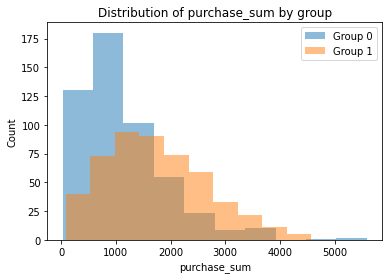

In [104]:
# Посмотрим на распределения значений по группам
users_df.groupby('group')['purchase_sum'].plot(kind='hist', alpha=0.5, legend=True)

plt.xlabel('purchase_sum')
plt.ylabel('Count')
plt.title('Distribution of purchase_sum by group')
plt.legend(['Group 0', 'Group 1'])

plt.show()


#### Как мы видим распределения значений в группах не нормальные, попробуем прологарифмировать данные

In [56]:
users_df['purchase_sum_log'] = np.log(users_df.purchase_sum)

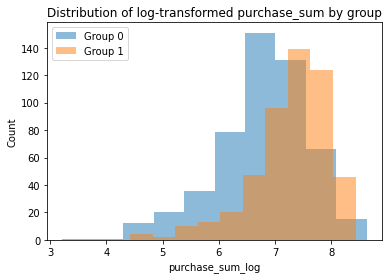

In [105]:
import matplotlib.pyplot as plt

users_df.groupby('group')['purchase_sum_log'].plot(kind='hist', alpha=0.5, legend=True)

plt.xlabel('purchase_sum_log')
plt.ylabel('Count')
plt.title('Distribution of log-transformed purchase_sum by group')
plt.legend(['Group 0', 'Group 1'])

plt.show()


#### Распределения стали чуть больше похожими на нормальные, но  не идеально, и тест на нормальность это подтвердил:

In [86]:
stats.shapiro(users_df[users_df['group'] == 0]['purchase_sum_log'])

ShapiroResult(statistic=0.9639690518379211, pvalue=7.013428171553926e-10)

In [87]:
stats.shapiro(users_df[users_df['group'] == 1]['purchase_sum_log'])

ShapiroResult(statistic=0.9233786463737488, pvalue=2.724891650548165e-15)

#### В целом наши выборки довольно большие и данные с такими распределениями уже можно сравнивать t-тестом. 
Для верности проведем тест на исходных данных и на прологарифмированных.
Ну и все же, т.к. распределения не являются нормальными, лишний раз проверим себя и используем непараметрический аналог t-теста – U-критерий Манна-Уитни

In [88]:
stats.ttest_ind(users_df[users_df['group'] == 0]['purchase_sum'], users_df[users_df['group'] == 1]['purchase_sum'])

Ttest_indResult(statistic=-11.225235903309473, pvalue=1.2229806926590577e-27)

In [89]:
stats.ttest_ind(users_df[users_df['group'] == 0]['purchase_sum_log'], users_df[users_df['group'] == 1]['purchase_sum_log'])


Ttest_indResult(statistic=-11.083914022889402, pvalue=5.032969014294083e-27)

In [90]:
stats.mannwhitneyu(users_df[users_df['group'] == 0]['purchase_sum'], users_df[users_df['group'] == 1]['purchase_sum'])

MannwhitneyuResult(statistic=75128.5, pvalue=3.674232946509265e-30)

#### Во всех случаях мы получили p-value значительно меньше 0.05. 
Это говорит нам о том, что суммы покупок пользователей статистически значимо отличаются. И мы с высокой степенью вероятности можем утверждать - новая рекомендательная система положительно повлияла на нашу ключевую метрику.

#### Подобным образом сравним остальные наши метрики

#### Среднее количество покупок в неделю

In [109]:
# Cредние значения
group_0 = users_df.query('group==0').purchase_week.mean()
group_1 = users_df.query('group==1').purchase_week.mean()

group_0, group_1

(1.4912109375, 2.377245508982036)

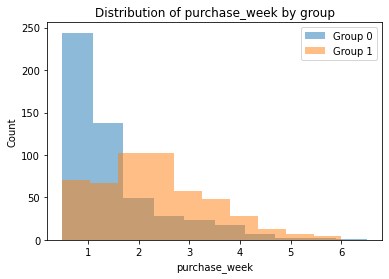

In [101]:
# Распределение значений
users_df.groupby('group')['purchase_week'].plot(kind='hist', alpha=0.5, legend=True)

plt.xlabel('purchase_week')
plt.ylabel('Count')
plt.title('Distribution of purchase_week by group')
plt.legend(['Group 0', 'Group 1'])

plt.show()



In [66]:
users_df['purchase_week_log'] = np.log(users_df.purchase_week)

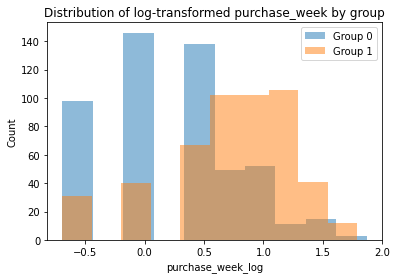

In [103]:
# Распределение прологарифмированных значений
users_df.groupby('group')['purchase_week_log'].plot(kind='hist', alpha=0.5, legend=True)

plt.xlabel('purchase_week_log')
plt.ylabel('Count')
plt.title('Distribution of log-transformed purchase_week by group')
plt.legend(['Group 0', 'Group 1'])

plt.show()


In [68]:
stats.ttest_ind(users_df.query('group==0').purchase_week, users_df.query('group==1').purchase_week)

Ttest_indResult(statistic=-13.993124788985595, pvalue=8.430777321728061e-41)

In [69]:
stats.ttest_ind(users_df.query('group==0').purchase_week_log, users_df.query('group==1').purchase_week_log)

Ttest_indResult(statistic=-14.526145736482459, pvalue=1.460250358304666e-43)

In [70]:
stats.mannwhitneyu(users_df.query('group==0').purchase_week, users_df.query('group==1').purchase_week)

MannwhitneyuResult(statistic=62993.5, pvalue=1.2199751971495041e-45)

#### Так же как и в первом случае, все тесты показали, что есть статистически значимые различия между средним количеством покупок в неделю у пользователей в тестовой и контрольной группе

#### Средняя сумма покупки

In [110]:
# Cредние значения
group_0 = purchase_df.query('group==0').order_price.mean()
group_1 = purchase_df.query('group==1').order_price.mean()

group_0, group_1

(382.09292730844794, 368.86162888329136)

#### В данном случае наша метрика в тестовой группе меньше, чем в контрольной, проверим является ли данная разница статистически значимой


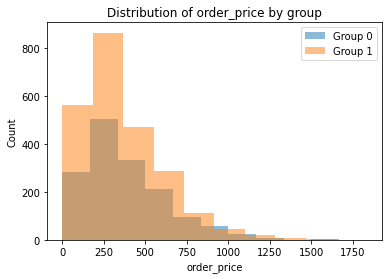

In [96]:
# Распределение значений
purchase_df.groupby('group')['order_price'].plot(kind='hist', alpha=0.5, legend=True)

plt.xlabel('order_price')
plt.ylabel('Count')
plt.title('Distribution of order_price by group')
plt.legend(['Group 0', 'Group 1'])

plt.show()


In [73]:
purchase_df['order_price_log'] = np.log(purchase_df.order_price)

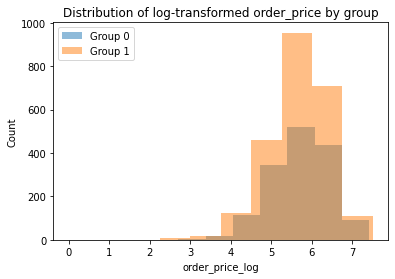

In [98]:
# Распределение прологарифмированных значений
purchase_df.groupby('group')['order_price_log'].plot(kind='hist', alpha=0.5, legend=True)

plt.xlabel('order_price_log')
plt.ylabel('Count')
plt.title('Distribution of log-transformed order_price by group')
plt.legend(['Group 0', 'Group 1'])

plt.show()


In [93]:
stats.ttest_ind(purchase_df.loc[purchase_df['group'] == 0, 'order_price'], purchase_df.loc[purchase_df['group'] == 1, 'order_price'])

Ttest_indResult(statistic=1.6334875192269402, pvalue=0.10244707728234669)

In [92]:
stats.ttest_ind(purchase_df.loc[purchase_df['group'] == 0, 'order_price_log'], purchase_df.loc[purchase_df['group'] == 1, 'order_price_log'])

Ttest_indResult(statistic=1.7522118532194424, pvalue=0.07981582868828002)

In [91]:
stats.mannwhitneyu(purchase_df.loc[purchase_df['group'] == 0, 'order_price'], purchase_df.loc[purchase_df['group'] == 1, 'order_price'])


MannwhitneyuResult(statistic=1879868.0, pvalue=0.07539952478041778)

#### Некоторые выводы:
- Так как значение p-value больше 0,05 во всех проведенных тестах, у нас нет статистически значимых оснований для отклонения нулевой гипотезы. Это означает, что нет достаточных доказательств для того, чтобы утверждать, что средняя сумма покупки в тестовой и контрольной группе статистически значимо отличается.

#### Из данных полученных после проведенного А/В-теста, мы имеем следующие результаты:
- Средняя сумма покупок пользователей за две недели в тестовой группе с новой системой рекомендаций составила 1753 руб., в группе со старой версией приложения - 1139руб.
- Среднее количество покупок в неделю - 2.38 и 1.49 соответственно.

Мы имеем достаточно доказательств, чтобы утверждать, что различия в данных не случайны и являются результатом использования новой системы рекомендаций товаров. Это подтверждает, что мы должны применить данную рекомендательную систему ко всем пользователям.